**this is a template notebook for Assignment 4 on Recommendation. To get a 60 you will need to complete chapter 1.
    The template is also just an indication. You can add more cells if needed, and can of course delete this line**

# <span style ='background:yellow'>Assignment Week 7 Recommendation Systems
Author: <span style='background:yellow'>Mohaymen Sameen</span><br>
Student number: <span style='background:yellow'>627650</span><br>
Date: <span style='background:yellow'>12th June 2021</span>

For this notebook to work you must have installed the following packages (usually via pip install *packageName*:

* pandas

From these we will need the following libraries:

In [1]:
# enter here all those 'from .... import ....'
import pandas as pd

# 1. The Item-Based Recommender

We are going to build an item-based recommender for **<span style='background:yellow'>Artists</span>**. In this recommender we could for example **<span style='background:yellow'>select an Artist and it will give correlated artists back to us based on other users' listening counts and patterns</span>**.

To begin we'll need to load some data.

In [2]:
# Reading data file
df = pd.read_csv('lastfm/user_artists.dat', sep='\t', names=['user_ID', 'artist_ID', 'ListeningCount'])

**<span style='background:yellow'>The file which is being read is the user artists data file. The user_artists data file contains the artists listened by each user. It also provides a listening count for each [user, artist] pair.
</span>**

In [3]:
#Converting from object to float because it wouldnt merge
df['artist_ID'] = pd.to_numeric(df['artist_ID'], errors='coerce', downcast='integer')
df['user_ID'] = pd.to_numeric(df['user_ID'], errors='coerce', downcast='integer')
df['ListeningCount'] = pd.to_numeric(df['ListeningCount'], errors='coerce', downcast='integer')

#using this format to convert it into integer. 
#https://stackoverflow.com/questions/21291259/convert-floats-to-ints-in-pandas
pd.options.display.float_format = '{:,.0f}'.format

df.dropna()
df.head()

,user_ID,artist_ID,ListeningCount
0,nan,nan,nan
1,2,51,"13,883"
2,2,52,"11,690"
3,2,53,"11,351"
4,2,54,"10,300"


In [4]:
artists = pd.read_csv('lastfm/artists.dat', sep='\t')
artists = artists[['id', 'name']]
artists = artists.rename(columns={"id": "artist_ID"})

artists['artist_ID'] = artists['artist_ID'].astype(float)
artists.head()

,artist_ID,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


In [5]:
#Merging
df2 = pd.merge(df, artists, on='artist_ID')
df2.head()

,user_ID,artist_ID,ListeningCount,name
0,2,51,"13,883",Duran Duran
1,4,51,228,Duran Duran
2,27,51,85,Duran Duran
3,28,51,10,Duran Duran
4,62,51,528,Duran Duran


We need one row per user, and his/her scores for each **<span style='background:yellow'>artist name</span>**. We can do this by creating a pivot table.

In [6]:
# Creating pivot table
artist_matrix = df2.pivot_table(index='user_ID', columns='name', values='ListeningCount')

#I think the reason we see so many nan values is because there are so many different
#artists which users do not listen to. Out of 17632 artists, lets assume a user listens
#to around 100 artists. It would be difficult to find those artists he listens to out of 17632

artist_matrix.head()

name,!!!,!DISTAIN,!deladap,#####,#2 Orchestra,$lick,$lick feat. Six-Fo,(1962-1966),(Pre) Kingdom,(We Are) Performance,...,티아라,현아,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ,ｂｏｏｇｉｅｍａｎ,ｂｏｒｎ,ｍａｃｈｉｎｅ
user_ID,,,,,,,,,,,,,,,,,,,,,
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


We also need to take the counts into consideration so lets keep those into their own dataframe, together with the average score:

In [7]:
# code to make a dataframe with the unique objects, their average score and the number of scores
ListeningCount = pd.DataFrame(df2.groupby('name')['ListeningCount'].mean())
ListeningCount['nListeningCount'] = df2.groupby('name')['ListeningCount'].count()
ListeningCount.head()

,ListeningCount,nListeningCount
name,,
!!!,"1,413",2
!DISTAIN,628,2
!deladap,65,1
#####,463,8
#2 Orchestra,144,1


To decide on a cut-off point as minimum number of scores to be eligable we can plot the number of scores in a histogram:

<AxesSubplot:>

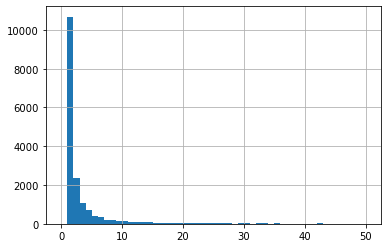

In [8]:
# Generating the histogram
ListeningCount['nListeningCount'].hist(bins=50, range=(0,50))

From the histogram we can see that **<span style='background:yellow'>the listening count average of the artists is on the y-axis and the counts for the listening counts is on the x-axis based on grouping by artist names. We have used the range from 0 to 50 for the graph because there were no counts more than 50. We use 5 as the cut-off value because we don't want to recommend users artists which have barely any listeners. So hence we use the cut-off value as 5</span>**

Finally we can create the code to perform a recommendation. First we can select one particular **<span style='background:yellow'>artist, lets use Duran Duran.</span>**

In [9]:
# Selecting field
myArtist = artist_matrix['Duran Duran']

And then to find the recommendation based on the correlations.

In [10]:
# code to create the recommendation
myCorrs = artist_matrix.corrwith(myArtist).sort_values(ascending=False)

# and as a dataframe
corrDf = pd.DataFrame(myCorrs, columns=['Correlation'])
corrDf.dropna(inplace=True)
corrDf.sort_values('Correlation', ascending=False)
corrDf.head()

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
name,
Mark Knopfler,1
Barry Manilow,1
Nephew,1
New Kids on the Block,1
Nightwish,1


**<span style='background:yellow'>In this correlation matrix we can see the artists which are closely correlated to Duran Duran. For example, if users listen to Duran Duran, they can also listen to Mark Knopfler, Barry Manilow and etc etc since they are correlated.</span>**

It might be nice to have one simple function that could do all the work for us. It should have as input parameter a field and then returns the recommendation:

In [11]:
# python function for choosing an artist
def artist_recommendation(field):
    myArtist = artist_matrix[field]
    myCorrs = artist_matrix.corrwith(myArtist).sort_values(ascending=False)
    corrDf = pd.DataFrame(myCorrs, columns=['Correlation'])
    corrDf.dropna(inplace=True)
    corrDf.sort_values('Correlation', ascending=False)
    corrDf = corrDf.merge(ListeningCount['nListeningCount'], on='name')    
    print(corrDf[corrDf['nListeningCount']>=5].head())


Lets test the function:

In [12]:
# testing the function
artist_recommendation("Duran Duran")

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


                       Correlation  nListeningCount
name                                               
Mark Knopfler                    1                5
New Kids on the Block            1               12
Nightwish                        1              103
Opeth                            1               68
Orbital                          1               12


<font size="5"><center>-----Chapters 1 is required to be fully completed to get a 60, the next few chapters will give a +10 for each chapter.<br> 
    However no template is available for these chapters. You will have to create it yourself.
    ----</center></font>

# 2. Negative correlations

The recommenders so far used, are looking at what if I give a high rating for this, what do you then recommend me. But how about if I give a low rating for something, what would you then recommend me?

# 3. Content Based

Add a chapter showing how a basic content based recommender might work. A starting point for this might be https://www.datacamp.com/community/tutorials/recommender-systems-python (at about 1/3 of the page it starts explaining this in the section called ‘Content based’.

# 4. User Based

Add a chapter showing how a basic user based recommender might work. A starting point for this might be https://realpython.com/build-recommendation-engine-collaborative-filtering/

# 5. Combination

Combine two or more recommendation techniques to get an even better recommendation